In [ ]:
!unzip CCPD2019-dl1.zip

In [ ]:
!pip install torchmetrics

In [ ]:
!pip install pybind11
!pip install fastwer

In [73]:
import torchvision
import numpy as np
import torch
import os
from torch import nn
from torchvision import transforms
from PIL import Image
from tqdm.notebook import tqdm
import fastwer
import torchmetrics
from sklearn.metrics import accuracy_score
from madgrad import MADGRAD
import matplotlib.pyplot as plt

In [36]:
train_transform = transforms.Compose([
    transforms.Resize((32, 200)),
    transforms.RandomGrayscale(0.5),
    transforms.RandomRotation(0.2),
    transforms.ColorJitter(),
    transforms.GaussianBlur(kernel_size=(5, 5)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((32, 200)),
    transforms.ToTensor(),
])

In [38]:
path_to_files = 'CCPD2019-dl1/CCPD2019-dl1/'

In [39]:
unk_token = '<UNK>'
blank_token = '<BLANK>'

In [40]:
class Tokenizer:
    def __init__(self, labels):
        self.char2id = {}
        self.char2id[unk_token] = 0
        self.char2id[blank_token] = 1
        for i, label in enumerate(labels):
                self.char2id[label] = i + 2
        self.id2char = {v:k for k, v in self.char2id.items()}
        
    def encode(self, label):
        enc_label = [self.char2id[char] if char in self.char2id else self.char2id[unk_token] for char in label]
        return enc_label
    
    def __len__(self):
        return len(self.char2id)
    
    def decode(self, enc_list):
        decoded_list = ''
        for i, char in enumerate(enc_list):
            if (char != self.char2id[unk_token] and char != self.char2id[blank_token] and not(i > 0 and char == enc_list[i - 1])):
                decoded_list += self.id2char[char]
        return decoded_list

In [7]:
alph = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽",
        "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁",
        "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵",
        "云", "藏", "陕", "甘", "青", "宁", "新", "警",
        "学", "O", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H',
        'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R',
        'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
        '0', '1', '2', '3', '4', '5', '6', '7',
        '8', '9', 'O']
tokenizer = Tokenizer(alph)

In [8]:
class OCRDataset(torch.utils.data.Dataset):
    def __init__(self, path, transform, tokenizer):
        super().__init__()
        self.files = os.listdir(path)[:80000]
        self.t = transform
        self.labels = [file.split('-')[1] for file in self.files]
        self.path = path
        self.alphabet = {}
        self.tokenizer = tokenizer
        self.encoded_labels = [self.tokenizer.encode(label) for label in self.labels]
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, ind):
        image = Image.open(f'{self.path}{self.files[ind]}')
        img = self.t(image)
        label = self.labels[ind]
        return img, label, self.encoded_labels[ind]

In [42]:
train_dataset = OCRDataset(path_to_files + 'train/', train_transform, tokenizer)

In [43]:
test_dataset = OCRDataset(path_to_files + 'test/', test_transform, tokenizer)

In [44]:
class downsample(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding=1,use_batchnorm=True):
    super().__init__()
    if use_batchnorm:
      self.core=nn.Sequential(
          nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
          nn.BatchNorm2d(out_channels),
          nn.ReLU()
      )
    else:
      self.core=nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.ReLU()
    )
  def forward(self, x):
    return self.core(x)

In [45]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
        downsample(in_channels=3, out_channels=64, kernel_size=3, stride=1),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        downsample(in_channels=64, out_channels=128, kernel_size=3, stride=1),
        nn.MaxPool2d(kernel_size = (1,2), stride = 2),
        downsample(in_channels=128, out_channels=256, kernel_size=3, stride=1),
        nn.MaxPool2d(kernel_size = (1,2), stride = 2),
        downsample(in_channels=256, out_channels=128, kernel_size=3, stride=1),
        )
    def forward(self, inputs):
        x = self.layers(inputs)
        return x

In [47]:
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout = 0.1):
        super().__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, dropout = dropout, batch_first = True, bidirectional = True)
        
    def forward(self, inputs):
        outp, _ = self.rnn(inputs)
        return outp

In [48]:
class CRNN(nn.Module):
    def __init__(self, output_dim,  hidden_dim, max_len = 15, num_layers = 2):
        super().__init__()
        self.encoder = Encoder()
        self.avg_pool = nn.AdaptiveAvgPool2d((max_len, max_len))
        self.rnn = BiLSTM(max_len, hidden_dim, num_layers)
        self.classify_layer = nn.Sequential(
            nn.Linear(hidden_dim * 2, max_len),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(max_len, output_dim)
        )
    
    def forward(self, inputs):
        outp = self.encoder(inputs)
        b, c, h, w = outp.shape
        outp = outp.view(b, c * h, w)
        outp = self.avg_pool(outp)
        outp = outp.transpose(1,2)
        outp = self.rnn(outp)
        outp = self.classify_layer(outp)
        outp = outp.permute(1, 0, 2)
        outp = nn.functional.log_softmax(outp, dim=2)
        return outp

In [49]:
def collate_fn(batch):
    images, labels, encoded_labels = zip(*batch)
    images = torch.stack(images, 0)
    encoded_labels = torch.nn.utils.rnn.pad_sequence(torch.tensor(encoded_labels), batch_first=True, padding_value=1)
    return images, labels, encoded_labels

In [85]:
def train_epoch(model,
               dataset,
               loss_f,
               optimizer,
               scheduler,
               device:str = 'cuda'):
    epoch_loss = 0
    model = model.to(device)
    model.train()
    for img, label, encoded_label in tqdm(dataset):
        
        batch = img.shape[0]
        
        img = img.to(device)
        encoded_label = encoded_label.to(device)
        optimizer.zero_grad()
        
        preds = model(img)
        p_labels = torch.full(size = (batch,), fill_value = preds.size(0), dtype = torch.long)
        t_labels = torch.full(size = (batch,), fill_value = encoded_label.size(1), dtype = torch.long)

        loss = loss_f(preds, encoded_label, p_labels, t_labels)
        
        epoch_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    
    return epoch_loss / len(dataset)

In [84]:
def eval_epoch(model,
               dataset,
               loss_f,
               device:str = 'cuda'):
    preds = []
    real = []
    epoch_loss = 0
    model = model.to(device)
    model.eval()
    for img, label, encoded_label in tqdm(dataset):
        
        with torch.no_grad():
            batch = img.shape[0]

            img = img.to(device)
            encoded_label = encoded_label.to(device)

            preds = model(img)
            
            p_labels = torch.full(size = (batch,), fill_value = preds.size(0), dtype = torch.long)
            t_labels = torch.full(size = (batch,), fill_value = encoded_label.size(1), dtype = torch.long)

            loss = loss_f(preds, encoded_label, p_labels, t_labels)

            epoch_loss += loss.item()
    
    return epoch_loss / len(dataset)

In [52]:
def train_model(model, 
                train_dataset,
                test_dataset,
                batch_size,
                epochs,
                loss_f,
                optimizer,
                scheduler,
                device:str = 'cuda'):
    
    model.cuda()
    loss_f.to(device)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False, collate_fn = collate_fn)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn = collate_fn)
    for epoch_i in range(epochs):
        print('------------------------')
        print(f'Epoch: {epoch_i}')
        train_loss = train_epoch(model, train_dataloader, loss_f, optimizer, scheduler, device)
        eval_loss = eval_epoch(model, test_dataloader, loss_f, device)
        scheduler.step(eval_loss)
        save_model(model, epoch_i)
        print(f'Train loss: {train_loss}')
        print(f'Eval loss: {eval_loss}')
        

In [53]:
def save_model(model, epoch_i):
    torch.save(model, f'sv_2/model_{epoch_i}.pt')

In [54]:
model = CRNN(max_len = 15, hidden_dim = 200, output_dim = len(train_dataset.tokenizer), num_layers = 2) 

loss_f =  nn.CTCLoss(blank = 1, reduction = 'mean', zero_infinity = True)
optimizer = MADGRAD(model.parameters(), lr = 1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=5, verbose=True) 

In [55]:
import gc 
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
train_model(
    model = model,
    train_dataset = train_dataset,
    test_dataset = test_dataset,
    batch_size = 64,
    loss_f = loss_f,
    optimizer = optimizer,
    scheduler = scheduler,
    epochs = 20,
    device = 'cuda'
)

In [86]:
def get_results(model, dataset, tokenizer, device = 'cuda'):
    preds = []
    real = []
    epoch_loss = 0
    model = model.to(device)
    model.eval()
    test_dataloader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle = False, collate_fn = collate_fn)
    for img, label, encoded_label in tqdm(test_dataloader):
        
        with torch.no_grad():
            batch = img.shape[0]

            img = img.to(device)
            encoded_label = encoded_label.to(device)

            pred = model(img)

            preds.append(tokenizer.decode(pred.argmax(2).squeeze(1).tolist()))
            real.append(label)
    
    return preds, real

In [62]:
preds, real_labels = get_results(model, test_dataset, tokenizer)

  0%|          | 0/9999 [00:00<?, ?it/s]

In [63]:
accuracy = torchmetrics.CharErrorRate()

In [64]:
accuracy(preds, real_labels) / 100

tensor(0.0700)

In [65]:
accuracy_score(preds, real_labels)

0.9490949094909491

## Модель может ошибаться из-за некачетсвенных изображений, например испорчченный номер, блюр и тд. Посмотрим на 10 самых плохих изобрадений по CER loss

In [68]:
cer_losses = np.array([accuracy(preds[i], real_labels[i]) for i in range(len(preds))])

In [79]:
img_ids = np.argpartition(cer_losses, -10)[-10:]

In [80]:
len(img_ids)

10

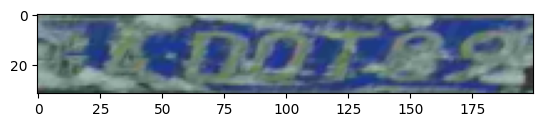

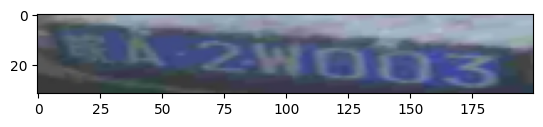

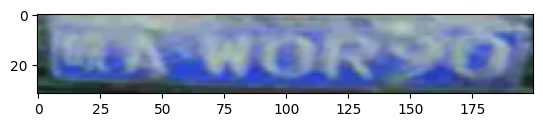

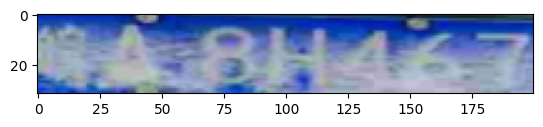

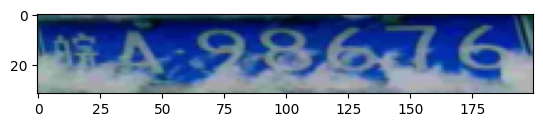

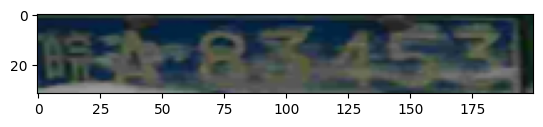

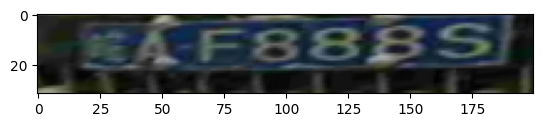

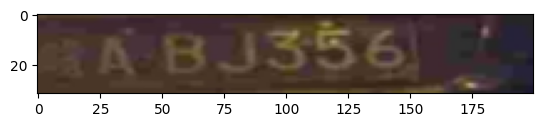

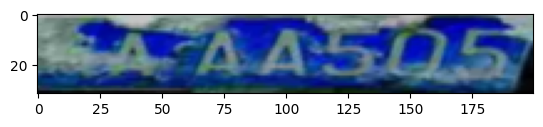

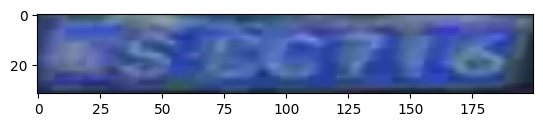

In [82]:
for i in img_ids:
    plt.imshow(test_dataset[i][0].permute(1, 2, 0))
    plt.show()

## Гипотеза подтведилась, модель ошибается, на знаках, которые повреждены

## Честно будет обратить внимание на то, что я урезал количество картинок на трейне, чтобы модель бустрее обучилась на пк, если мы увеличим количесвто картинок, то и получим лучшее качество